In [7]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import minmax_scale
from joblib import load
import scipy
#import your prediction file

predfile = pd.read_csv('example_predictions.csv')

#download the latest tournament file

dtype_dict = load('dtype_dict1.joblib')
TOURNAMENT_DATAPATH = 'https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz'
df_tournament = pd.read_csv(TOURNAMENT_DATAPATH, dtype=dtype_dict)
features = [c for c in df_tournament if c.startswith("feature")]

from sklearn.preprocessing import minmax_scale
import scipy
from sklearn.preprocessing import MinMaxScaler
def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()
def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)
def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]

df_tournament['preds'] = predfile.prediction
df_tournament['neutralized_preds'] = df_tournament.groupby("era").apply(lambda x: normalize_and_neutralize(x, ["preds"], features, 1)) #set your proportion as something between 1 (fully neutralized) and something >0)
scaler = MinMaxScaler()
df_tournament['neutralized_preds'] = scaler.fit_transform(df_tournament[['neutralized_preds']])

In [8]:
df_val = df_tournament[df_tournament.data_type == "validation"].copy()

C:\Users\jtaylo98\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


getting per era scores
performance over time


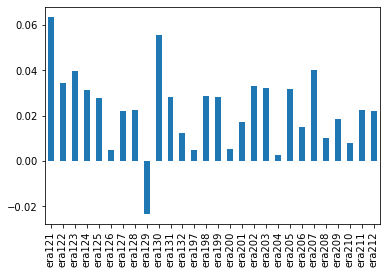

Maximum Drawdown (Minimum Score)
-0.02357441186016226
Average Correlation
0.022778613932814468
Median Correlation
0.022603936735999593
Variance
0.00028663326153134276
Std. Dev.
0.01693024694242062
Autocorrelation
-0.15569338156729526
Sharpe
4.66073729365108
Smart Sharpe
3.934371476287852
Numerai Sharpe
2.5296903032549682
Skewness
-0.10234315421976732
Excess Kurtosis
1.0465043185704026
Standard Error of the Mean
0.003258227543217794
Annualized Sharpe
2.5296903032549682
Adjusted Sharpe
3.7381954045436
Value at Risk (VaR) with 10% probability of occurring
-0.02286057752357739
Smart Sortino Ratio
1.5248114366521073
Sortino Ratio
1.7737739338236276
Average Feature Exposure
0.009921251537407147
Maximum Feature Exposure
0.02417425673260388


In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(12))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]


era_col = df_val.era
new_df = df_val.copy()
new_df['era'] = era_col
preds = df_val.neutralized_preds
new_df["pred"] = preds
era_scores = pd.Series(index=new_df['era'].unique())
print("getting per era scores")
for era in new_df['era'].unique():
    era_df = new_df[new_df['era'] == era]
    era_scores[era] = spearmanr(era_df['pred'], era_df['target'])
era_scores.sort_values(inplace=True)
era_scores.sort_index(inplace=True)
era_scores.plot(kind="bar")
print("performance over time")
plt.show()

print("Maximum Drawdown (Minimum Score)")
print(np.min(era_scores))
print("Average Correlation")
print(np.mean(era_scores))
print("Median Correlation")
print(np.median(era_scores))
print("Variance")
print(np.var(era_scores))
print("Std. Dev.")
print(np.std(era_scores))
print("Autocorrelation")
print(ar1(era_scores))
print("Sharpe")
print(np.mean(era_scores)/np.std(era_scores) * np.sqrt(12))
print("Smart Sharpe")
print(smart_sharpe(era_scores))
print("Numerai Sharpe")
print(numerai_sharpe(era_scores))
import scipy 
from scipy.stats import skew, kurtosis, sem, gmean
from scipy.stats import spearmanr

print("Skewness")
print(skew(era_scores))
print("Excess Kurtosis")
print(kurtosis(era_scores))
print("Standard Error of the Mean")
print(sem(era_scores))


def annual_sharpe(x):
    return ((np.mean(x) -0.010415154) /np.std(x)) * np.sqrt(12)

print("Annualized Sharpe")
print(annual_sharpe(era_scores))
def adj_sharpe(x):
    return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - ((kurtosis(x) - 3) / 24) * (annual_sharpe(x) ** 2))
print("Adjusted Sharpe")
print(adj_sharpe(era_scores))

def VaR(x):
    return -np.mean(x) - np.sqrt(np.var(x)) * np.percentile(x, 10)
print("Value at Risk (VaR) with 10% probability of occurring")
print(VaR(era_scores))
def smart_sortino_ratio(x, target=0.010415154):
    xt = x - target
    return np.mean(xt)/(((np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5)*autocorr_penalty(x))
print("Smart Sortino Ratio")
print(smart_sortino_ratio(era_scores))
def sortino_ratio(x, target=0.010415154):
    xt = x - target
    return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5
print("Sortino Ratio")
print(sortino_ratio(era_scores))

PREDICTION_NAME = 'pred'
def feature_exposures(df):
    feature_names = [f for f in df.columns
                     if f.startswith("feature")]
    exposures = []
    for f in feature_names:
        fe = spearmanr(df[PREDICTION_NAME], df[f])[0]
        exposures.append(fe)
    return np.array(exposures)


def max_feature_exposure(df):
    return np.max(np.abs(feature_exposures(df)))


def feature_exposure(df):
    return np.sqrt(np.mean(np.square(feature_exposures(df))))
print("Average Feature Exposure")
print(feature_exposure(new_df))
print("Maximum Feature Exposure")
print(max_feature_exposure(new_df))